# --The Start--

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyomo.environ import *

## Data

In [38]:
df=pd.read_csv('ED1 data.csv', sep=',')
df

,Unnamed: 0,a,b,c,Pmin,Pmax
0,G1,3.00,20.00,100.00,28,206
1,G2,4.05,18.07,98.87,90,284
2,G3,4.05,15.55,104.26,68,189
3,G4,3.99,19.21,107.21,76,266
4,G5,3.88,26.18,95.31,19,53


\begin{align}
    \min_{g} && \sum_g a_gP_g^2 +b_gP_g +c_g\\
    \text{s.t.} && \sum_{g} P_g \geq Load\\
    && P^{min}_g \leq P_g \leq P^{max}_g

\end{align}

In [39]:
print(f'The number of the Generators: {len(df)}')

The number of the Generators: 5


## Formulation

In [40]:
model = AbstractModel()

model.g = RangeSet(len(df))


# P는 g로 인덱싱 중
# P를 찾는 중이니까 Var.
# bound에 대한 constraint는 여기서 바로 넣어줌.
def bound_P(model, g):
    return (df.loc[g-1, 'Pmin'], df.loc[g-1, 'Pmax'])
model.P = Var(model.g, bounds=bound_P, initialize=0, within=Reals)


# Load는 주어지니까 Param.
model.Load = Param(initialize=300, within=Reals)


# Objective Function
def rule_of(model):
    # pandas는 0부터 세니까 (g-1)으로 쓴 거임
    return sum(df.loc[g-1, 'a']*model.P[g] + df.loc[g-1, 'b']*model.P[g] + df.loc[g-1, 'c']  for g in model.g)
model.objective = Objective(rule=rule_of, sense=minimize)


# Constraints
def rule_c1(model):
    return sum(model.P[g] for g in model.g) >= model.Load
model.c1 = Constraint(rule=rule_c1)

## 최적화 수행

In [41]:
opt = SolverFactory('ipopt')
instance = model.create_instance()
results = opt.solve(instance) # solves and updates instance

WARNING (W1002): Setting Var 'P[1]' to a numeric value `0` outside the bounds
    (28, 206).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'P[1]' to a numeric value `0` outside the bounds
    (28, 206).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'P[2]' to a numeric value `0` outside the bounds
    (90, 284).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'P[3]' to a numeric value `0` outside the bounds
    (68, 189).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'P[4]' to a numeric value `0` outside the bounds
    (76, 266).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'P[5]' to a numeric value `0` outside the bounds
    (19, 53).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002


In [42]:
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 5
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.9.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.03999829292297363
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [43]:
print("Constraint 1 is active at the optimal solution:", model.c1.active)

Constraint 1 is active at the optimal solution: True


In [44]:
for g in instance.g:
    print(g , value(instance.P[g]))
    
Total= sum(value(instance.P[g]) for g in instance.g )
print(Total)

1 28.0
2 90.0
3 86.99999912746073
4 76.0
5 19.0
299.99999912746074


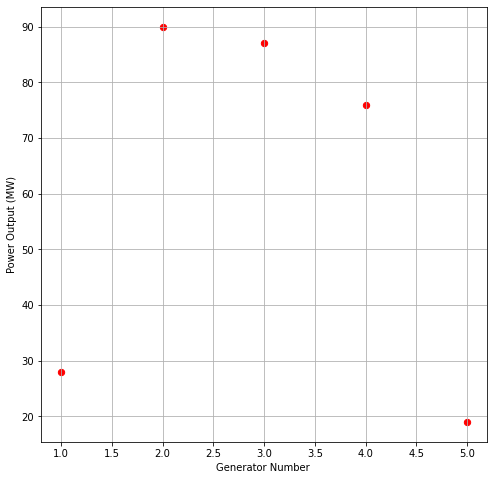

In [45]:
plt.figure(figsize=(8,8))
Y=[value(instance.P[g]) for g in instance.g]
X=[g for g in instance.g]
plt.scatter(X,Y,s=40, c='r')
plt.xlabel('Generator Number ')
plt.ylabel('Power Output (MW)')
plt.grid()
plt.show()

## --The end--